## Flow to extract the main topic from a sentence.

References:

> [Structured Entity Extraction Using Large Language Models](https://arxiv.org/pdf/2402.04437v3)

> [Simple topic extraction](https://medium.com/analytics-vidhya/fun-with-topic-extraction-8aa11e0437d0)

> [Effective sentence-level relation extraction model using entity-centric dependency tree](https://peerj.com/articles/cs-2311/)

> [Universal sentence encoder based intent representation](https://medium.com/webknossos/enhancing-intent-classification-with-the-universal-sentence-encoder-ecbcd7a3005c)

> https://www.researchgate.net/publication/371175645_Assessing_Word_Importance_Using_Models_Trained_for_Semantic_Tasks

In [1]:
# Install required packages for first run. 
# %pip install tensorflow_hub #Uncomment to install if needed.

In [2]:
#Import necessary packages.
import tensorflow_hub as hub
import tensorflow as tf

In [24]:
# Example sentences (Just some random news headlines)
sentences = [
    "Air India crash LIVE | 'On highest alert, all rescue teams mobilised,' says Civil Aviation Minister",
    "Israel Gave Patriot Missiles To Ukraine? Bibi's 'Panic Call' To Putin After Diplomat's Big Reveal",
    "Epic Games Files Lawsuit Against Fortnite Cheat Developer.",
    "Iran-Israel tensions rise. Why India should worry",
    "Lawsuit by Epic Games against Fortnite cheat developer highlights the ongoing battle against online gaming cheats.",
]

### Attempt 1: Most important Word: [Let's not use this]
Conculsion - The word 'Air India' -> Takes the most important word as Air. This Removes a majority of the context as the word is completely irrelevant to the line in this case. Need to look for something that retains some amout of context. Perhaps encoded representation of Subject or phrase or the entire sentence.

In [25]:
#Simple topic extraction
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from itertools import combinations
import networkx as nx

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

def extract_important_word(text):
    # Tokenize the text into words
    words = word_tokenize(text.lower())
    
    # Remove stopwords and non-alphabetic tokens
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.isalpha() and word not in stop_words]
    
    # Create a graph where nodes are words
    graph = nx.Graph()
    graph.add_nodes_from(filtered_words)
    
    # Add edges between co-occurring words
    for word1, word2 in combinations(filtered_words, 2):
        if graph.has_edge(word1, word2):
            graph[word1][word2]['weight'] += 1
        else:
            graph.add_edge(word1, word2, weight=1)
    
    # Apply the TextRank algorithm
    scores = nx.pagerank(graph, weight='weight')
    
    # Find the word with the highest score
    important_word = max(scores, key=scores.get)
    return important_word

# Example usage
important_word = extract_important_word(sentences[0])
print("Most important word:", important_word)

Most important word: air


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adith\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\adith\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Method 2: Encoded representation [Seems good]

In [26]:
#universal encoder based:

# Load the Universal Sentence Encoder model
model_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #This is around 1 GB in size, it took a while for me to run this.
embed = hub.load(model_url)

# Generate embeddings
embeddings = embed(sentences)

# Display embeddings
for i, sentence in enumerate(sentences):
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embeddings[i][:5]}...")  # Displaying just the first 5 dimensions 


Sentence: Air India crash LIVE | 'On highest alert, all rescue teams mobilised,' says Civil Aviation Minister
Embedding: [ 0.01937982 -0.02905347 -0.00861647  0.03616101  0.05966667]...
Sentence: Israel Gave Patriot Missiles To Ukraine? Bibi's 'Panic Call' To Putin After Diplomat's Big Reveal
Embedding: [ 0.00129161 -0.04412462 -0.00500471 -0.02924727  0.02072357]...
Sentence: Epic Games Files Lawsuit Against Fortnite Cheat Developer.
Embedding: [-0.02254904 -0.02632329  0.00212709  0.01274655  0.06480744]...
Sentence: Iran-Israel tensions rise. Why India should worry
Embedding: [-0.00372241 -0.04914428  0.00075184  0.02198449  0.0018583 ]...
Sentence: Lawsuit by Epic Games against Fortnite cheat developer highlights the ongoing battle against online gaming cheats.
Embedding: [ 0.00078867  0.00313604  0.00014297 -0.03127715  0.0288633 ]...


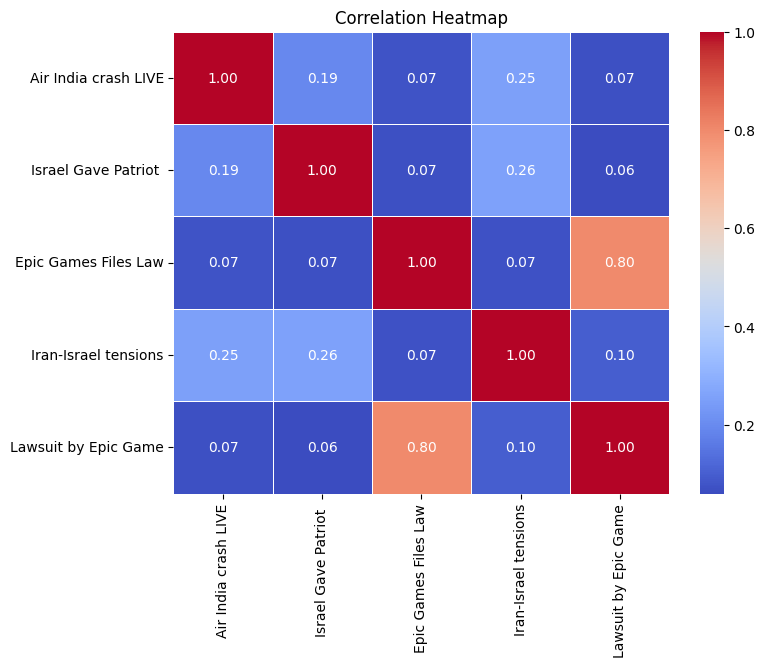

In [27]:
# Checking out the correlation matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = {}
for i, sentence in enumerate(sentences):
    data[sentence[0:20]] = embeddings[i]

df = pd.DataFrame(data)
correlation_matrix = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Notes:
This seems to work well. News articles with similar context or content will be treated similarly. We could perhaps use this encoding combined with the sentiment on a decision tree based algorithm (XGboost, Lightgbm or any Gradient boosted algorithm perhaps ) - to generate the final Prediction.

In [ ]:
def embed_sentences(sentences):
    if(type(sentences) == str):
        sentences = [sentences]
    model_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #This is around 1 GB in size, it took a while for me to run this.
    embed = hub.load(model_url)

    # Generate embeddings
    embeddings = embed(sentences)
    return embeddings